In [1]:
import os
import cv2
import random
import albumentations as A
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import save_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

2025-09-11 10:07:25.973574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757585246.169954      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757585246.226496      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = "/kaggle/input/plantify/new agumanted dataset2"   # Original dataset
save_path = "/content/drive/MyDrive/DataSet/new agumanted dataset2"  # Save augmented images

In [3]:
os.makedirs(save_path, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=30,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


In [4]:
#  Preprocessing Function

def preprocess_image(img_path):
    # Load with OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Denoising
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # 2. Gaussian Blur (remove small noise)
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # 3. Sharpening filter
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    return img

In [5]:
# Apply Preprocessing + Augmentation + Save

num_augmented = 10

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    if os.path.isdir(folder_path):
        save_class_dir = os.path.join(save_path, folder)
        os.makedirs(save_class_dir, exist_ok=True)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            try:
                # Preprocess image
                img = preprocess_image(img_path)

                # Resize (important for keras generator, e.g., 224x224)
                img = cv2.resize(img, (224, 224))

                # Convert to array
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Augment and save
                i = 0
                for batch in datagen.flow(x, batch_size=1,
                                          save_to_dir=save_class_dir,
                                          save_prefix='aug',
                                          save_format='jpg'):
                    i += 1
                    if i >= num_augmented:
                        break
            except:
                print(f"Skipped file: {img_path}")


# Model

In [6]:
dataset_dir = "/kaggle/input/plantify/new agumanted dataset2"

In [7]:
batch_size = 32
img_size = (224, 224)

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,   # 80% train, 20% test
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 10593 files belonging to 11 classes.
Using 8475 files for training.


I0000 00:00:1757588290.397019      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
valid_data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 10593 files belonging to 11 classes.
Using 2118 files for validation.


In [10]:
print(f'The total nummber of classes is {len(train_data.class_names)}')
class_labels = train_data.class_names
class_labels

The total nummber of classes is 11


['Corn_healthy',
 'Corn_mildew',
 'Corn_rust',
 'Soyabean_healthy',
 'Soyabean_leaf_spots',
 'Soyabean_rust',
 'Soyabean_yellow_virus',
 'Tomato_bacterial',
 'Tomato_healthy',
 'Tomato_leaf_spot',
 'Tomato_powdery_mildew']

In [11]:
# STEP 3: Preprocess Data for ResNet50
# Normalize inputs using ResNet50's preprocess_input

preprocess = tf.keras.layers.Lambda(preprocess_input)

train_data = train_data.map(lambda x, y: (preprocess(x), y))
valid_data = valid_data.map(lambda x, y: (preprocess(x), y))

# Improve performance with prefetching
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#  Count the number of images for each disease and plot the distribution
diseases = os.listdir(dataset_dir)

nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(dataset_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class


,no. of images
Corn_mildew,774
Soyabean_healthy,1489
Corn_healthy,1758
Soyabean_yellow_virus,1081
Corn_rust,690
Tomato_healthy,1772
Soyabean_leaf_spots,839
Tomato_bacterial,373
Soyabean_rust,750
Tomato_leaf_spot,725


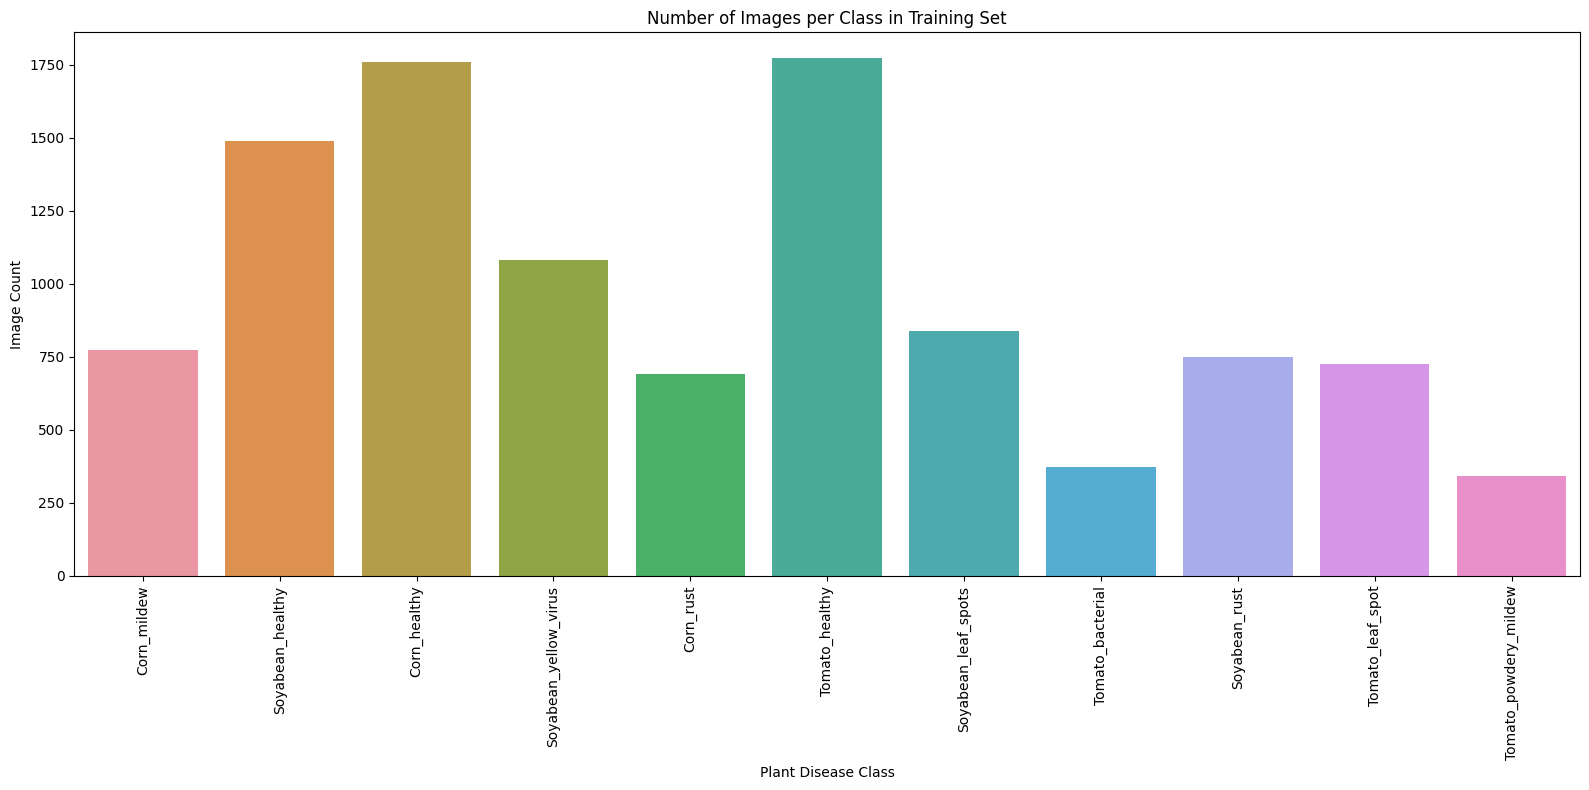

In [13]:
plt.figure(figsize=(16, 8))
sns.barplot(x=img_per_class.index, y=img_per_class["no. of images"])
plt.xticks(rotation=90)
plt.title("Number of Images per Class in Training Set")
plt.xlabel("Plant Disease Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


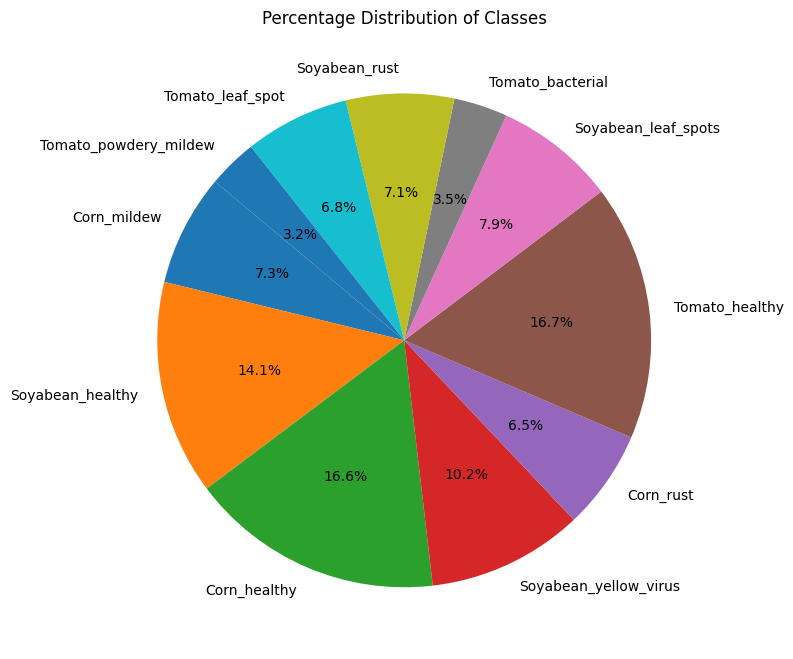

In [14]:
plt.figure(figsize=(8, 8))
img_per_class["no. of images"].plot.pie(autopct='%1.1f%%', startangle=140, legend=False)
plt.title("Percentage Distribution of Classes")
plt.ylabel("")  # Removes y-axis label
plt.tight_layout()
plt.show()

In [15]:
# STEP 4: Build ResNet50 Model
# ============================================
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base layers first
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(len(class_labels), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15
)


Epoch 1/15


I0000 00:00:1757588307.958383      66 service.cc:148] XLA service 0x7cfe9c0022b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757588307.959468      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757588309.628365      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/265 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.0781 - loss: 3.2674  

I0000 00:00:1757588313.968337      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


265/265 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.4419 - loss: 1.8285 - val_accuracy: 0.7446 - val_loss: 0.7562
Epoch 2/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.6985 - loss: 0.8929 - val_accuracy: 0.7823 - val_loss: 0.6153
Epoch 3/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.7443 - loss: 0.7230 - val_accuracy: 0.7767 - val_loss: 0.5898
Epoch 4/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7785 - loss: 0.6283 - val_accuracy: 0.8376 - val_loss: 0.4555
Epoch 5/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7950 - loss: 0.5762 - val_accuracy: 0.8319 - val_loss: 0.4464
Epoch 6/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8087 - loss: 0.5369 - val_accuracy: 0.8475 - val_loss: 0.4209
Epoch 7/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8278 - loss: 0.4887 - val_accuracy: 0.8612 - val_loss: 0.3748
Epoch 8/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8337 - loss: 0.4662 - val_accura

In [19]:
train_acc = model.evaluate(train_data)
print("Training accuracy : ", train_acc)

265/265 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9319 - loss: 0.1921
Training accuracy :  [0.18283064663410187, 0.9371091723442078]


In [20]:
test_acc = model.evaluate(valid_data)
print("Testing accuracy : ", test_acc)

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8794 - loss: 0.3177
Testing accuracy :  [0.3094906210899353, 0.8829084038734436]


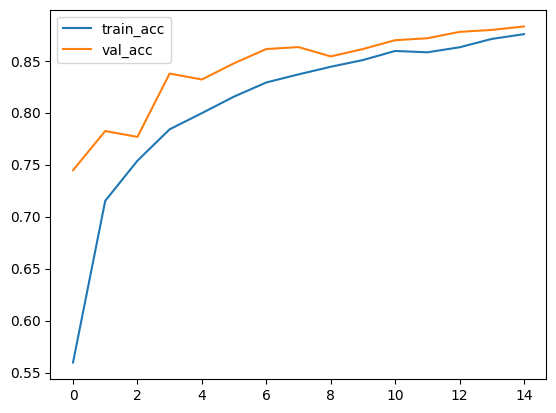

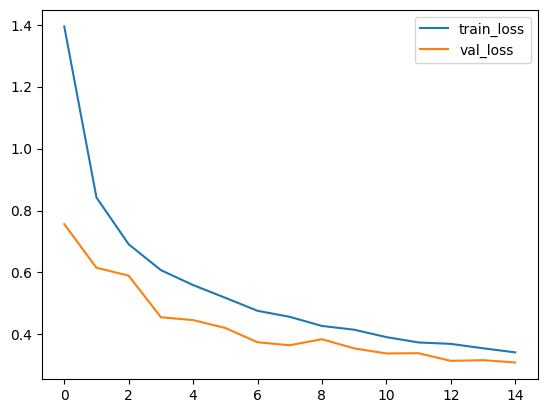

In [21]:
# STEP 9: Plot Accuracy & Loss
# ============================================
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
model.save("Crop_disease_resnet50.h5")